In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.feature_selection import SelectKBest, f_classif
import xgboost as xgb

In [ ]:
final_full_data = pd.read_csv("Full_data_features.csv")

In [ ]:
def site_de(x):
    if 'delaware' in x:
        return 'delaware'
    elif '/lu/' in x:
        return 'lu'
    elif 'mandarin' in x:
        return 'china'
    elif 'pitt' in x:
        return 'pitt'
    elif 'spanish' in x:
        return 'spain'
    elif 'ADReSS' in x:
        return "ADReSS"
    elif "TAUKADIAL" in x:
        return "TAUKADIAL"
    else:
        return None
final_full_data['site'] = final_full_data['path'].apply(site_de)


DLData = final_full_data
DLData['uid'] = DLData['ID']
DLData.drop(['ID','Unnamed: 0.1', 'Unnamed: 0', 'processed_path', 'path'], axis=1, inplace=True)
DLData['sex'] = DLData['sex'].fillna(DLData['gender'])
DLData = DLData.dropna(subset=['age', 'sex'])
DLData['sex'] = DLData['sex'].apply(lambda x: 1 if x.lower()[0] == 'm' else 0)
meta = pd.read_csv("additional_metadata.csv")
DLData = DLData.merge(meta[['uid', 'corpus']], on='uid', how='outer')
DLData['site'] = DLData['site'].fillna(DLData['corpus'])
DLData = DLData.drop('corpus', axis=1)
# DLData['split'] = DLData['site'].apply(lambda x: 'test' if x == 'pitt' else "train") 
DLData['split'] = DLData['language'].apply(lambda x: 'test' if x == 'mandarin' else "train") 
DLData = DLData.dropna(subset=['MCL', 'label'])

DLData[DLData['site'] == 'pitt']

In [4]:
# Cell 1: Import Libraries and Prepare Data
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Assume DLData is your dataframe
# For demonstration, if not defined, you can load it here, e.g., DLData = pd.read_csv('your_file.csv')

# Define non-feature columns to exclude
non_feature_cols = ['sex', 'site','mmse', 'label', 'MCL', 'dx', 'language', 'educ',
                    'gender', 'split', 'chunk_index', 'uid']

# Feature columns: all others, including audio features, age, sex
feature_cols = [col for col in DLData.columns if col not in non_feature_cols]

print(f"Number of features: {len(feature_cols)}")  # Should be >2000 + age + sex

# Filter train and test data
df_train_full = DLData[DLData['split'] == 'train'].copy()
df_test = DLData[DLData['split'] == 'test'].copy()

# Extract X_test and y_test
X_test = df_test[feature_cols].values  # As numpy array
y_test = df_test['label'].values

print(f"Test set shape: {X_test.shape}, y_test shape: {y_test.shape}")

Number of features: 2166
Test set shape: (41, 2166), y_test shape: (41,)


## Binary Classification Normal vs Abnormal

Train shape: (3306, 2166), y_train shape: (3306,)
Val shape: (778, 2166), y_val shape: (778,)


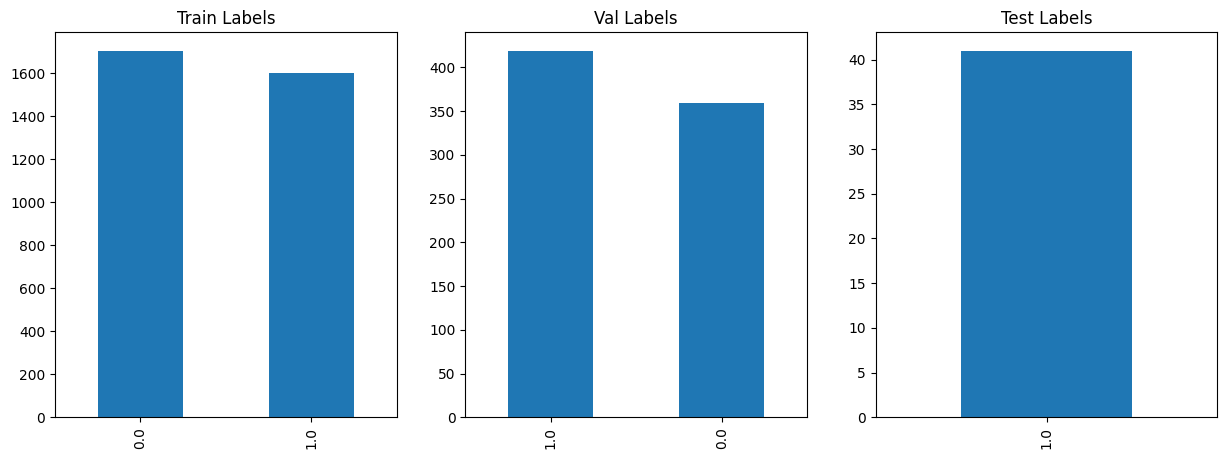

UID overlap between train and val: 0


In [5]:
# Cell 2: Grouped Split by UID to Prevent Leakage
# Get unique uids from train_full
unique_uids = df_train_full['uid'].unique()

# Split uids into train and val (80/20, random state for reproducibility)
train_uids, val_uids = train_test_split(unique_uids, test_size=0.2, random_state=42)

# Create train and val dataframes based on uids
df_train = df_train_full[df_train_full['uid'].isin(train_uids)]
df_val = df_train_full[df_train_full['uid'].isin(val_uids)]

# Extract X_train, y_train, X_val, y_val
X_train = df_train[feature_cols].values
y_train = df_train['label'].values

X_val = df_val[feature_cols].values
y_val = df_val['label'].values

print(f"Train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"Val shape: {X_val.shape}, y_val shape: {y_val.shape}")

# Optional: Visualize class distribution to check imbalance
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(15,5))
pd.Series(y_train).value_counts().plot(kind='bar', ax=axs[0])
axs[0].set_title('Train Labels')
pd.Series(y_val).value_counts().plot(kind='bar', ax=axs[1])
axs[1].set_title('Val Labels')
pd.Series(y_test).value_counts().plot(kind='bar', ax=axs[2])
axs[2].set_title('Test Labels')
plt.show()

# Verify no UID overlap
train_uid_set = set(df_train['uid'].unique())
val_uid_set = set(df_val['uid'].unique())
overlap = train_uid_set & val_uid_set
print(f"UID overlap between train and val: {len(overlap)}")  # Should be 0

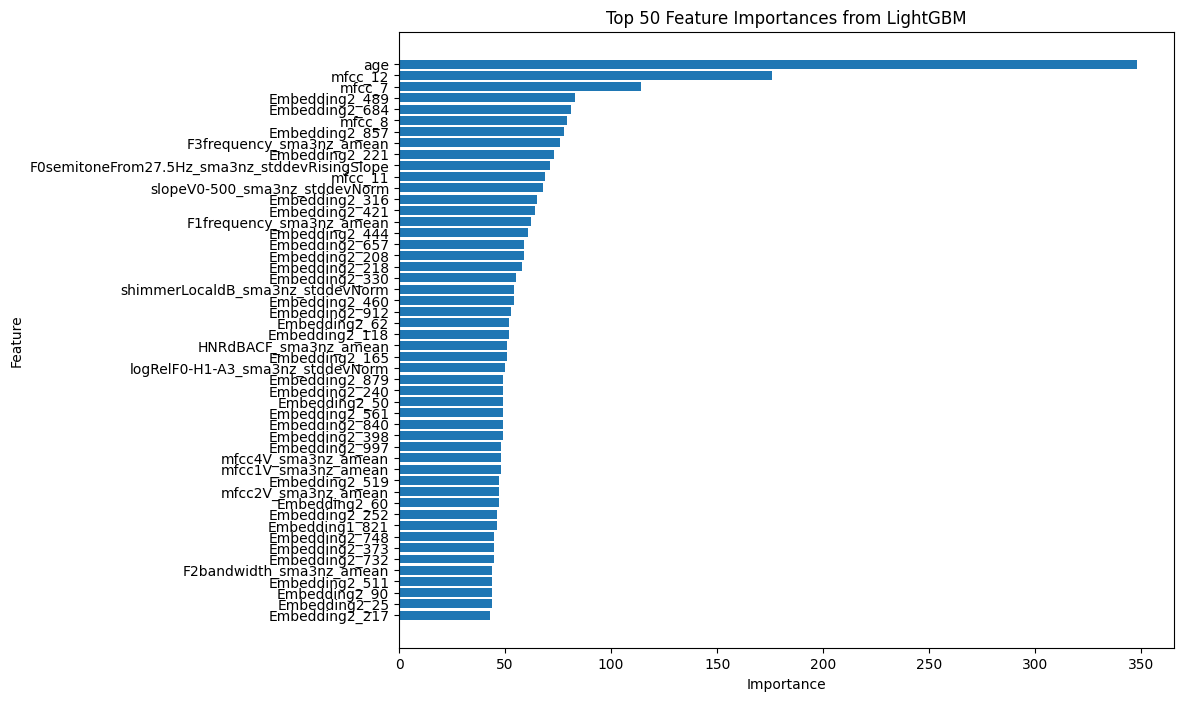

Top 10 Features by Importance:
                                            Feature  Importance
0                                               age         348
100                                         mfcc_12         176
95                                           mfcc_7         114
1630                                 Embedding2_489          83
1825                                 Embedding2_684          81
96                                           mfcc_8          79
1998                                 Embedding2_857          78
53                         F3frequency_sma3nz_amean          76
1362                                 Embedding2_221          73
8     F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope          71
Selected 500 features
Reduced shapes: Train (3306, 500), Val (778, 500), Test (41, 500)


In [6]:
# Cell 3: LightGBM for Feature Importance and Selection
import lightgbm as lgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Train LightGBM to get feature importances
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'device': 'gpu',  # GPU if available
    'is_unbalance': True,
    'verbose': -1,
    'random_state': 42
}

train_data = lgb.Dataset(X_train, label=y_train)
model_lgb = lgb.train(params, train_data, num_boost_round=1000)

# Get feature importances (split importance)
importances = model_lgb.feature_importance(importance_type='split')
feature_names = feature_cols  # Assuming feature_cols is list of column names

# Create dataframe for importances
imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
imp_df = imp_df.sort_values(by='Importance', ascending=False)

# Visualize top 50 features for clarity
top_n = 50
plt.figure(figsize=(10, 8))
plt.barh(imp_df['Feature'][:top_n], imp_df['Importance'][:top_n])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 50 Feature Importances from LightGBM')
plt.gca().invert_yaxis()
plt.show()

# Print top 10
print("Top 10 Features by Importance:")
print(imp_df.head(10))

# Select top 500 features (advanced selection based on tree splits)
n_select = 500
selected_features = imp_df['Feature'][:n_select].tolist()
print(f"Selected {len(selected_features)} features")

# Reduce datasets to selected features
# Get indices of selected features
selected_indices = [feature_cols.index(f) for f in selected_features]

X_train_sel = X_train[:, selected_indices]
X_val_sel = X_val[:, selected_indices]
X_test_sel = X_test[:, selected_indices]

print(f"Reduced shapes: Train {X_train_sel.shape}, Val {X_val_sel.shape}, Test {X_test_sel.shape}")

Validation Accuracy TabPFN: 0.7647814910025706
Validation Sensitivity TabPFN: 0.7159904534606205
Validation Specificity TabPFN: 0.8217270194986073
Validation AUC TabPFN: 0.8258487844117509
Confusion Matrix Val TabPFN:
[[295  64]
 [119 300]]


/home/siavash/anaconda3/envs/siavash/lib/python3.13/site-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


Test Accuracy TabPFN: 0.1951219512195122
Test Sensitivity TabPFN: 0.1951219512195122
Test Specificity TabPFN: 0
Test AUC TabPFN: nan
Confusion Matrix Test TabPFN:
[[ 0  0]
 [33  8]]


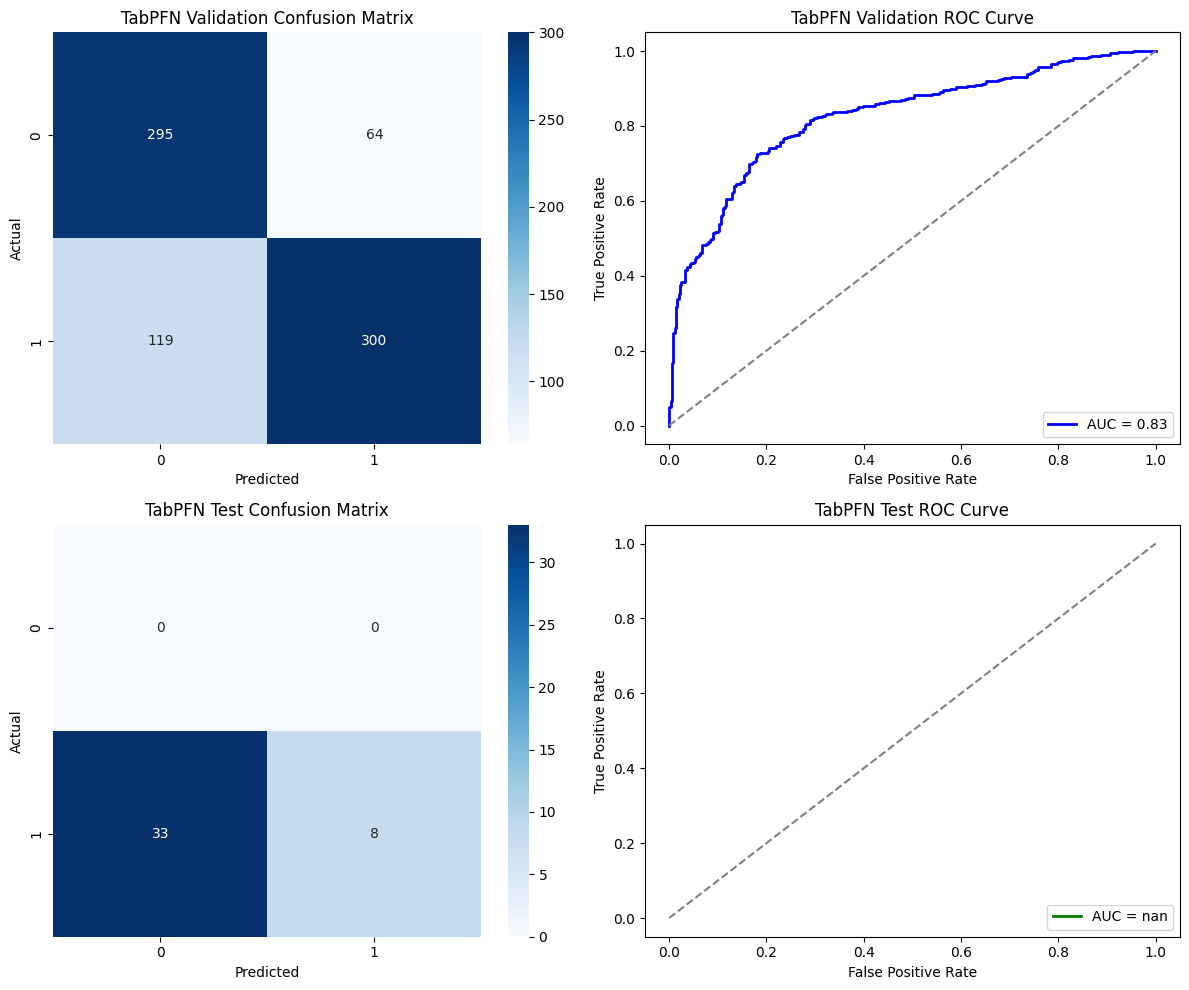

TabPFN Results Table:
          Set  Accuracy  Sensitivity  Specificity       AUC
0  Validation  0.764781     0.715990     0.821727  0.825849
1        Test  0.195122     0.195122     0.000000       NaN


In [7]:
# Cell 5: TabPFN Training, Validation, and Test with Comprehensive Metrics (Using Selected Features)
# Install if needed: !pip install tabpfn
from tabpfn import TabPFNClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Initialize TabPFN (use device='cuda' for GPU if available and installed with CUDA support)
model_tabpfn = TabPFNClassifier(device='cuda:0')

# Fit on selected train features
model_tabpfn.fit(X_train_sel, y_train)

# Function to compute metrics and plots
def compute_metrics(y_true, y_pred, y_prob, prefix):
    acc = accuracy_score(y_true, y_pred)
    conf = confusion_matrix(y_true, y_pred)
    if conf.shape == (2, 2):
        tn, fp, fn, tp = conf.ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    else:
        sensitivity = 0
        specificity = 0
    auc = roc_auc_score(y_true, y_prob) if len(np.unique(y_true)) > 1 else np.nan
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    return {
        'Accuracy': acc,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'AUC': auc
    }, conf, fpr, tpr

# Validation
y_pred_val_tabpfn = model_tabpfn.predict(X_val_sel)
y_prob_val_tabpfn = model_tabpfn.predict_proba(X_val_sel)[:, 1]
metrics_val, conf_val, fpr_val, tpr_val = compute_metrics(y_val, y_pred_val_tabpfn, y_prob_val_tabpfn, 'Val')

print(f"Validation Accuracy TabPFN: {metrics_val['Accuracy']}")
print(f"Validation Sensitivity TabPFN: {metrics_val['Sensitivity']}")
print(f"Validation Specificity TabPFN: {metrics_val['Specificity']}")
print(f"Validation AUC TabPFN: {metrics_val['AUC']}")
print("Confusion Matrix Val TabPFN:")
print(conf_val)

# Test
y_pred_test_tabpfn = model_tabpfn.predict(X_test_sel)
y_prob_test_tabpfn = model_tabpfn.predict_proba(X_test_sel)[:, 1]
metrics_test, conf_test, fpr_test, tpr_test = compute_metrics(y_test, y_pred_test_tabpfn, y_prob_test_tabpfn, 'Test')

print(f"Test Accuracy TabPFN: {metrics_test['Accuracy']}")
print(f"Test Sensitivity TabPFN: {metrics_test['Sensitivity']}")
print(f"Test Specificity TabPFN: {metrics_test['Specificity']}")
print(f"Test AUC TabPFN: {metrics_test['AUC']}")
print("Confusion Matrix Test TabPFN:")
print(conf_test)

# Create single figure with all plots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Val Confusion Matrix
sns.heatmap(conf_val, annot=True, fmt='d', cmap='Blues', ax=axs[0, 0])
axs[0, 0].set_xlabel('Predicted')
axs[0, 0].set_ylabel('Actual')
axs[0, 0].set_title('TabPFN Validation Confusion Matrix')

# Val ROC Curve
axs[0, 1].plot(fpr_val, tpr_val, color='blue', lw=2, label=f'AUC = {metrics_val["AUC"]:.2f}')
axs[0, 1].plot([0, 1], [0, 1], color='gray', linestyle='--')
axs[0, 1].set_xlabel('False Positive Rate')
axs[0, 1].set_ylabel('True Positive Rate')
axs[0, 1].set_title('TabPFN Validation ROC Curve')
axs[0, 1].legend(loc='lower right')

# Test Confusion Matrix
sns.heatmap(conf_test, annot=True, fmt='d', cmap='Blues', ax=axs[1, 0])
axs[1, 0].set_xlabel('Predicted')
axs[1, 0].set_ylabel('Actual')
axs[1, 0].set_title('TabPFN Test Confusion Matrix')

# Test ROC Curve
axs[1, 1].plot(fpr_test, tpr_test, color='green', lw=2, label=f'AUC = {metrics_test["AUC"]:.2f}')
axs[1, 1].plot([0, 1], [0, 1], color='gray', linestyle='--')
axs[1, 1].set_xlabel('False Positive Rate')
axs[1, 1].set_ylabel('True Positive Rate')
axs[1, 1].set_title('TabPFN Test ROC Curve')
axs[1, 1].legend(loc='lower right')

plt.tight_layout()
plt.show()

# Create single table with all results
results_df = pd.DataFrame({
    'Set': ['Validation', 'Test'],
    'Accuracy': [metrics_val['Accuracy'], metrics_test['Accuracy']],
    'Sensitivity': [metrics_val['Sensitivity'], metrics_test['Sensitivity']],
    'Specificity': [metrics_val['Specificity'], metrics_test['Specificity']],
    'AUC': [metrics_val['AUC'], metrics_test['AUC']]
})
print("TabPFN Results Table:")
print(results_df)

Validation Accuracy LGBM: 0.7737789203084833
Validation Sensitivity LGBM: 0.7374701670644391
Validation Specificity LGBM: 0.8161559888579387
Validation AUC LGBM: 0.8385265355236304
Confusion Matrix Val LGBM:
[[293  66]
 [110 309]]
Test Accuracy LGBM: 0.12195121951219512
Test Sensitivity LGBM: 0.12195121951219512
Test Specificity LGBM: 0
Test AUC LGBM: nan
Confusion Matrix Test LGBM:
[[ 0  0]
 [36  5]]


/home/siavash/anaconda3/envs/siavash/lib/python3.13/site-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


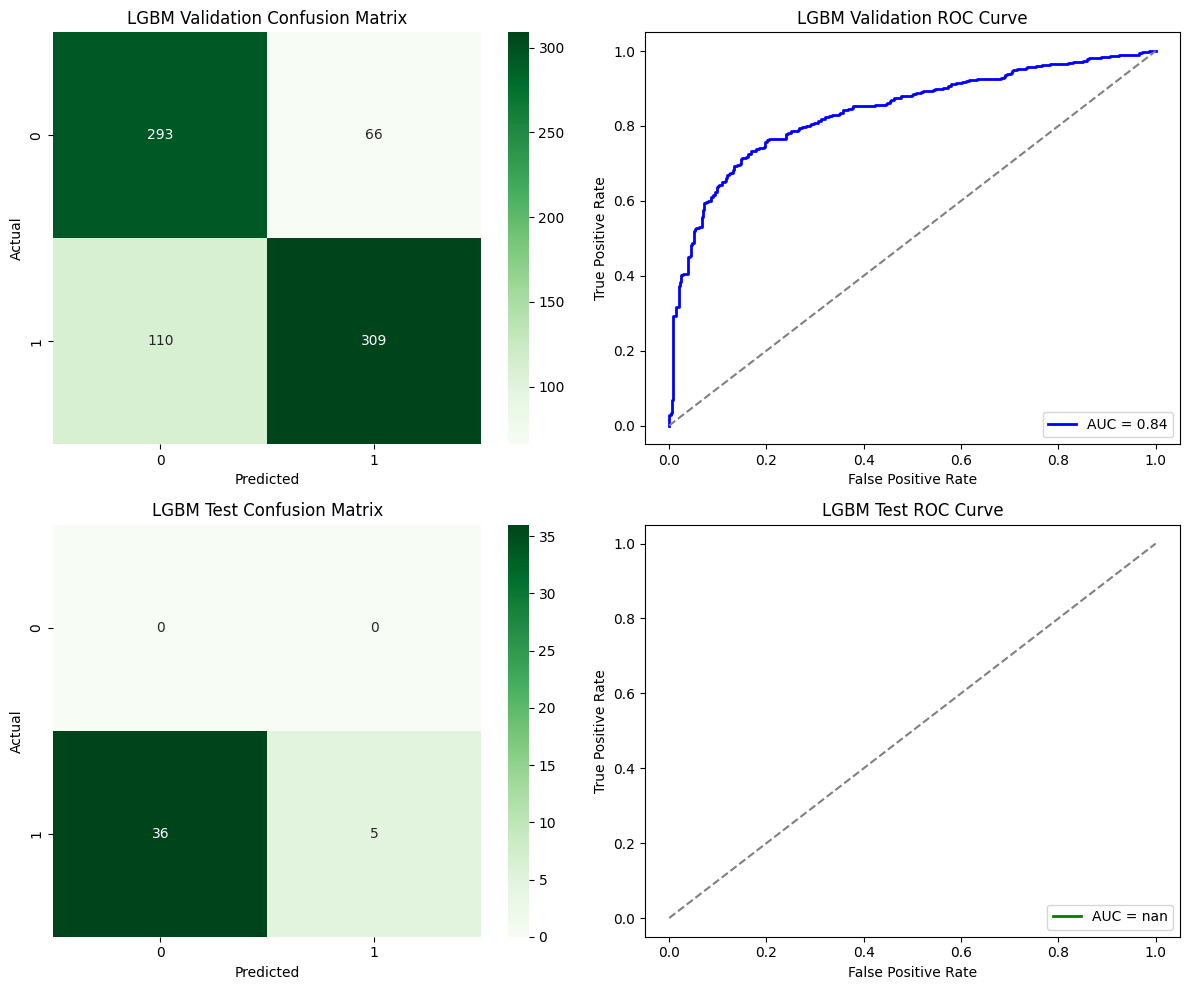

LGBM Results Table:
          Set  Accuracy  Sensitivity  Specificity       AUC
0  Validation  0.773779     0.737470     0.816156  0.838527
1        Test  0.121951     0.121951     0.000000       NaN


In [8]:
# Cell 3: LightGBM Training, Validation, and Test with Comprehensive Metrics
import lightgbm as lgb
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Train LightGBM
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'device': 'gpu',  # GPU if available
    'is_unbalance': True,
    'verbose': -1,
    'random_state': 42
}

train_data = lgb.Dataset(X_train_sel, label=y_train)  # Using selected features
val_data = lgb.Dataset(X_val_sel, label=y_val, reference=train_data)

model_lgb = lgb.train(params, train_data, num_boost_round=1000, valid_sets=[val_data])

# Function to compute metrics and plots (same as TabPFN)
def compute_metrics(y_true, y_pred, y_prob, prefix):
    acc = accuracy_score(y_true, y_pred)
    conf = confusion_matrix(y_true, y_pred)
    if conf.shape == (2, 2):
        tn, fp, fn, tp = conf.ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    else:
        sensitivity = 0
        specificity = 0
    auc = roc_auc_score(y_true, y_prob) if len(np.unique(y_true)) > 1 else np.nan
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    return {
        'Accuracy': acc,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'AUC': auc
    }, conf, fpr, tpr

# Validation
y_prob_val_lgb = model_lgb.predict(X_val_sel)
y_pred_val_lgb = (y_prob_val_lgb > 0.5).astype(int)
metrics_val, conf_val, fpr_val, tpr_val = compute_metrics(y_val, y_pred_val_lgb, y_prob_val_lgb, 'Val')

print(f"Validation Accuracy LGBM: {metrics_val['Accuracy']}")
print(f"Validation Sensitivity LGBM: {metrics_val['Sensitivity']}")
print(f"Validation Specificity LGBM: {metrics_val['Specificity']}")
print(f"Validation AUC LGBM: {metrics_val['AUC']}")
print("Confusion Matrix Val LGBM:")
print(conf_val)

# Test
y_prob_test_lgb = model_lgb.predict(X_test_sel)
y_pred_test_lgb = (y_prob_test_lgb > 0.5).astype(int)
metrics_test, conf_test, fpr_test, tpr_test = compute_metrics(y_test, y_pred_test_lgb, y_prob_test_lgb, 'Test')

print(f"Test Accuracy LGBM: {metrics_test['Accuracy']}")
print(f"Test Sensitivity LGBM: {metrics_test['Sensitivity']}")
print(f"Test Specificity LGBM: {metrics_test['Specificity']}")
print(f"Test AUC LGBM: {metrics_test['AUC']}")
print("Confusion Matrix Test LGBM:")
print(conf_test)

# Create single figure with all plots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Val Confusion Matrix
sns.heatmap(conf_val, annot=True, fmt='d', cmap='Greens', ax=axs[0, 0])
axs[0, 0].set_xlabel('Predicted')
axs[0, 0].set_ylabel('Actual')
axs[0, 0].set_title('LGBM Validation Confusion Matrix')

# Val ROC Curve
axs[0, 1].plot(fpr_val, tpr_val, color='blue', lw=2, label=f'AUC = {metrics_val["AUC"]:.2f}')
axs[0, 1].plot([0, 1], [0, 1], color='gray', linestyle='--')
axs[0, 1].set_xlabel('False Positive Rate')
axs[0, 1].set_ylabel('True Positive Rate')
axs[0, 1].set_title('LGBM Validation ROC Curve')
axs[0, 1].legend(loc='lower right')

# Test Confusion Matrix
sns.heatmap(conf_test, annot=True, fmt='d', cmap='Greens', ax=axs[1, 0])
axs[1, 0].set_xlabel('Predicted')
axs[1, 0].set_ylabel('Actual')
axs[1, 0].set_title('LGBM Test Confusion Matrix')

# Test ROC Curve
axs[1, 1].plot(fpr_test, tpr_test, color='green', lw=2, label=f'AUC = {metrics_test["AUC"]:.2f}')
axs[1, 1].plot([0, 1], [0, 1], color='gray', linestyle='--')
axs[1, 1].set_xlabel('False Positive Rate')
axs[1, 1].set_ylabel('True Positive Rate')
axs[1, 1].set_title('LGBM Test ROC Curve')
axs[1, 1].legend(loc='lower right')

plt.tight_layout()
plt.show()

# Create single table with all results
results_df = pd.DataFrame({
    'Set': ['Validation', 'Test'],
    'Accuracy': [metrics_val['Accuracy'], metrics_test['Accuracy']],
    'Sensitivity': [metrics_val['Sensitivity'], metrics_test['Sensitivity']],
    'Specificity': [metrics_val['Specificity'], metrics_test['Specificity']],
    'AUC': [metrics_val['AUC'], metrics_test['AUC']]
})
print("LGBM Results Table:")
print(results_df)

In [ ]:
# Cell 4: GBM (sklearn GradientBoostingClassifier) Training, Validation, and Test with Comprehensive Metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Initialize and train GBM (using selected features for efficiency)
model_gbm = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model_gbm.fit(X_train_sel, y_train)

# Use the same compute_metrics function
def compute_metrics(y_true, y_pred, y_prob, prefix):
    acc = accuracy_score(y_true, y_pred)
    conf = confusion_matrix(y_true, y_pred)
    if conf.shape == (2, 2):
        tn, fp, fn, tp = conf.ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    else:
        sensitivity = 0
        specificity = 0
    auc = roc_auc_score(y_true, y_prob) if len(np.unique(y_true)) > 1 else np.nan
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    return {
        'Accuracy': acc,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'AUC': auc
    }, conf, fpr, tpr

# Validation
y_prob_val_gbm = model_gbm.predict_proba(X_val_sel)[:, 1]
y_pred_val_gbm = model_gbm.predict(X_val_sel)
metrics_val, conf_val, fpr_val, tpr_val = compute_metrics(y_val, y_pred_val_gbm, y_prob_val_gbm, 'Val')

print(f"Validation Accuracy GBM: {metrics_val['Accuracy']}")
print(f"Validation Sensitivity GBM: {metrics_val['Sensitivity']}")
print(f"Validation Specificity GBM: {metrics_val['Specificity']}")
print(f"Validation AUC GBM: {metrics_val['AUC']}")
print("Confusion Matrix Val GBM:")
print(conf_val)

# Test
y_prob_test_gbm = model_gbm.predict_proba(X_test_sel)[:, 1]
y_pred_test_gbm = model_gbm.predict(X_test_sel)
metrics_test, conf_test, fpr_test, tpr_test = compute_metrics(y_test, y_pred_test_gbm, y_prob_test_gbm, 'Test')

print(f"Test Accuracy GBM: {metrics_test['Accuracy']}")
print(f"Test Sensitivity GBM: {metrics_test['Sensitivity']}")
print(f"Test Specificity GBM: {metrics_test['Specificity']}")
print(f"Test AUC GBM: {metrics_test['AUC']}")
print("Confusion Matrix Test GBM:")
print(conf_test)

# Create single figure with all plots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Val Confusion Matrix
sns.heatmap(conf_val, annot=True, fmt='d', cmap='Purples', ax=axs[0, 0])
axs[0, 0].set_xlabel('Predicted')
axs[0, 0].set_ylabel('Actual')
axs[0, 0].set_title('GBM Validation Confusion Matrix')

# Val ROC Curve
axs[0, 1].plot(fpr_val, tpr_val, color='blue', lw=2, label=f'AUC = {metrics_val["AUC"]:.2f}')
axs[0, 1].plot([0, 1], [0, 1], color='gray', linestyle='--')
axs[0, 1].set_xlabel('False Positive Rate')
axs[0, 1].set_ylabel('True Positive Rate')
axs[0, 1].set_title('GBM Validation ROC Curve')
axs[0, 1].legend(loc='lower right')

# Test Confusion Matrix
sns.heatmap(conf_test, annot=True, fmt='d', cmap='Purples', ax=axs[1, 0])
axs[1, 0].set_xlabel('Predicted')
axs[1, 0].set_ylabel('Actual')
axs[1, 0].set_title('GBM Test Confusion Matrix')

# Test ROC Curve
axs[1, 1].plot(fpr_test, tpr_test, color='green', lw=2, label=f'AUC = {metrics_test["AUC"]:.2f}')
axs[1, 1].plot([0, 1], [0, 1], color='gray', linestyle='--')
axs[1, 1].set_xlabel('False Positive Rate')
axs[1, 1].set_ylabel('True Positive Rate')
axs[1, 1].set_title('GBM Test ROC Curve')
axs[1, 1].legend(loc='lower right')

plt.tight_layout()
plt.show()

# Create single table with all results
results_df = pd.DataFrame({
    'Set': ['Validation', 'Test'],
    'Accuracy': [metrics_val['Accuracy'], metrics_test['Accuracy']],
    'Sensitivity': [metrics_val['Sensitivity'], metrics_test['Sensitivity']],
    'Specificity': [metrics_val['Specificity'], metrics_test['Specificity']],
    'AUC': [metrics_val['AUC'], metrics_test['AUC']]
})
print("GBM Results Table:")
print(results_df)